In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad

from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap

In [83]:
bgColor = "#F0F1EB"

In [114]:
def add_kde_to_ax(x, y, ax, *args, **kwargs):
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()
    
    X, Y = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    kde = gaussian_kde(np.vstack((x, y)))
    
    Z = np.reshape(kde(positions).T, X.shape)
    norm=plt.Normalize(Z.min(),Z.max())
    cmap = LinearSegmentedColormap.from_list("", [bgColor,"violet","blue"])
    
    ax.imshow(np.rot90(Z), cmap=cmap,
              extent=[xmin, xmax, ymin, ymax], aspect='auto', *args, **kwargs)

In [84]:
Salpeter = np.vectorize(lambda m, dm, xi0: quad(lambda m : xi0*(m)**(-2.35), m, m+dm)[0])
Kroupa = np.vectorize(lambda m, dm, xi0: quad(lambda m: xi0*m**-0.3 if m < 0.08 else (xi0*m**(-1.3) if 0.08 < m < 0.5 else xi0*m**(-2.3)), m, m+dm)[0])
ChabrierSingle = np.vectorize(lambda m, dm, xi0: (0.158*(1/np.log(10)*m)*np.exp((-(np.log(m)-np.log(0.08))**2)/(2*0.69**2)) if m < 1 else xi0*m**(-2.3)))

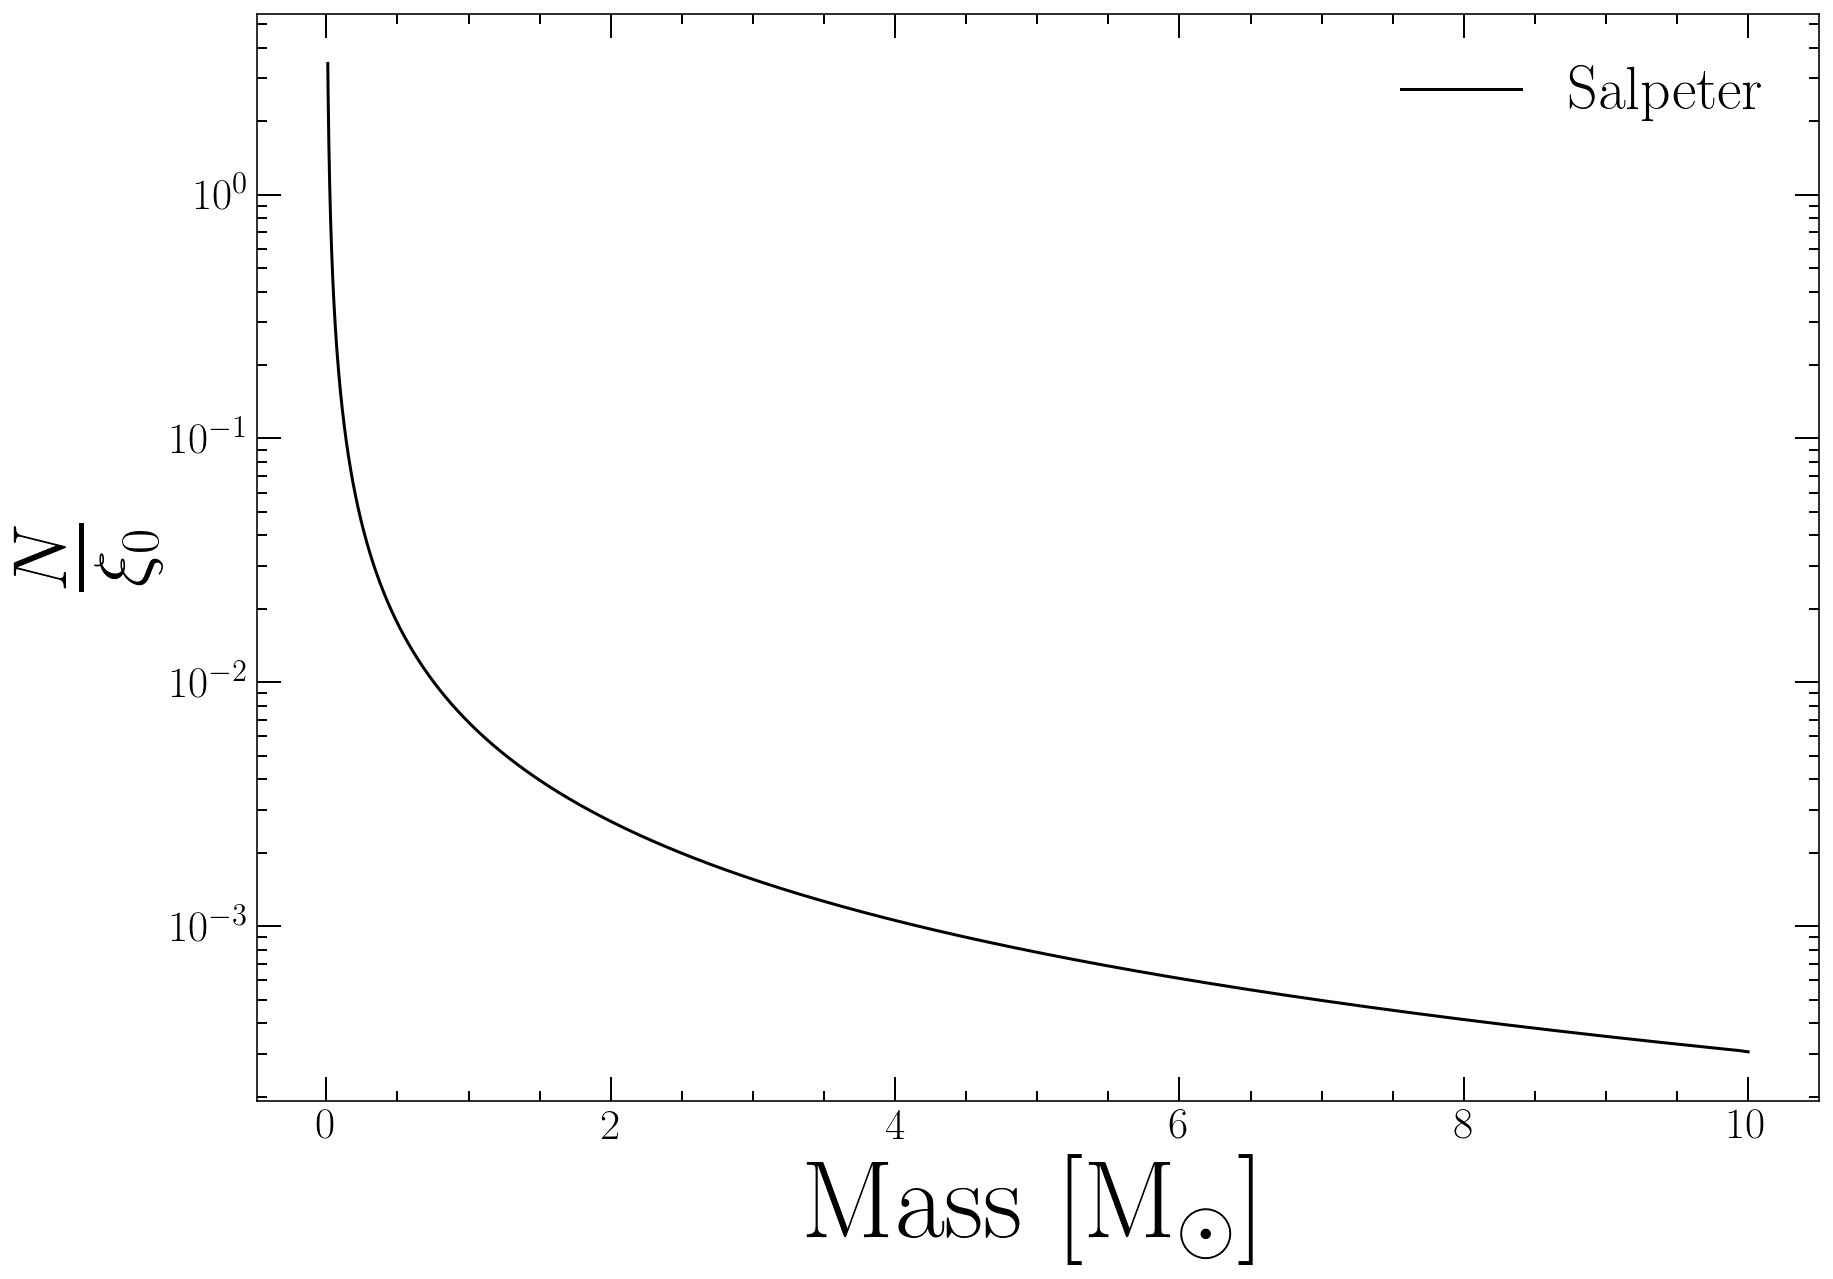

In [85]:
m = np.logspace(-2,1, 1000)
dm = np.gradient(m)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
# fig.patch.set_facecolor(bgColor)
# ax.set_facecolor(bgColor)
ax.semilogy(m, Salpeter(m, dm, 1), label='Salpeter', color='black')
# ax.semilogy(m, Kroupa(m, dm, 1), label='Kroupa', color='black', linestyle='dashed')
# ax.loglog(m, ChabrierSingle(m, 1), label="Chabrier Single")

ax.set_xlabel('Mass [M$_{\odot}$]', fontsize=55)
ax.set_ylabel(r'$\frac{N}{\xi_{0}}$', fontsize=55)


ax.legend(fontsize=30, frameon=False)

ax.tick_params(length=12, width=1)
ax.tick_params(length=5, width=1, which='minor')
ax.tick_params(axis='both', which='major', labelsize=22)

fig.savefig("figures/IMFJustSalpeter.png", bbox_inches="tight", transparent=True)

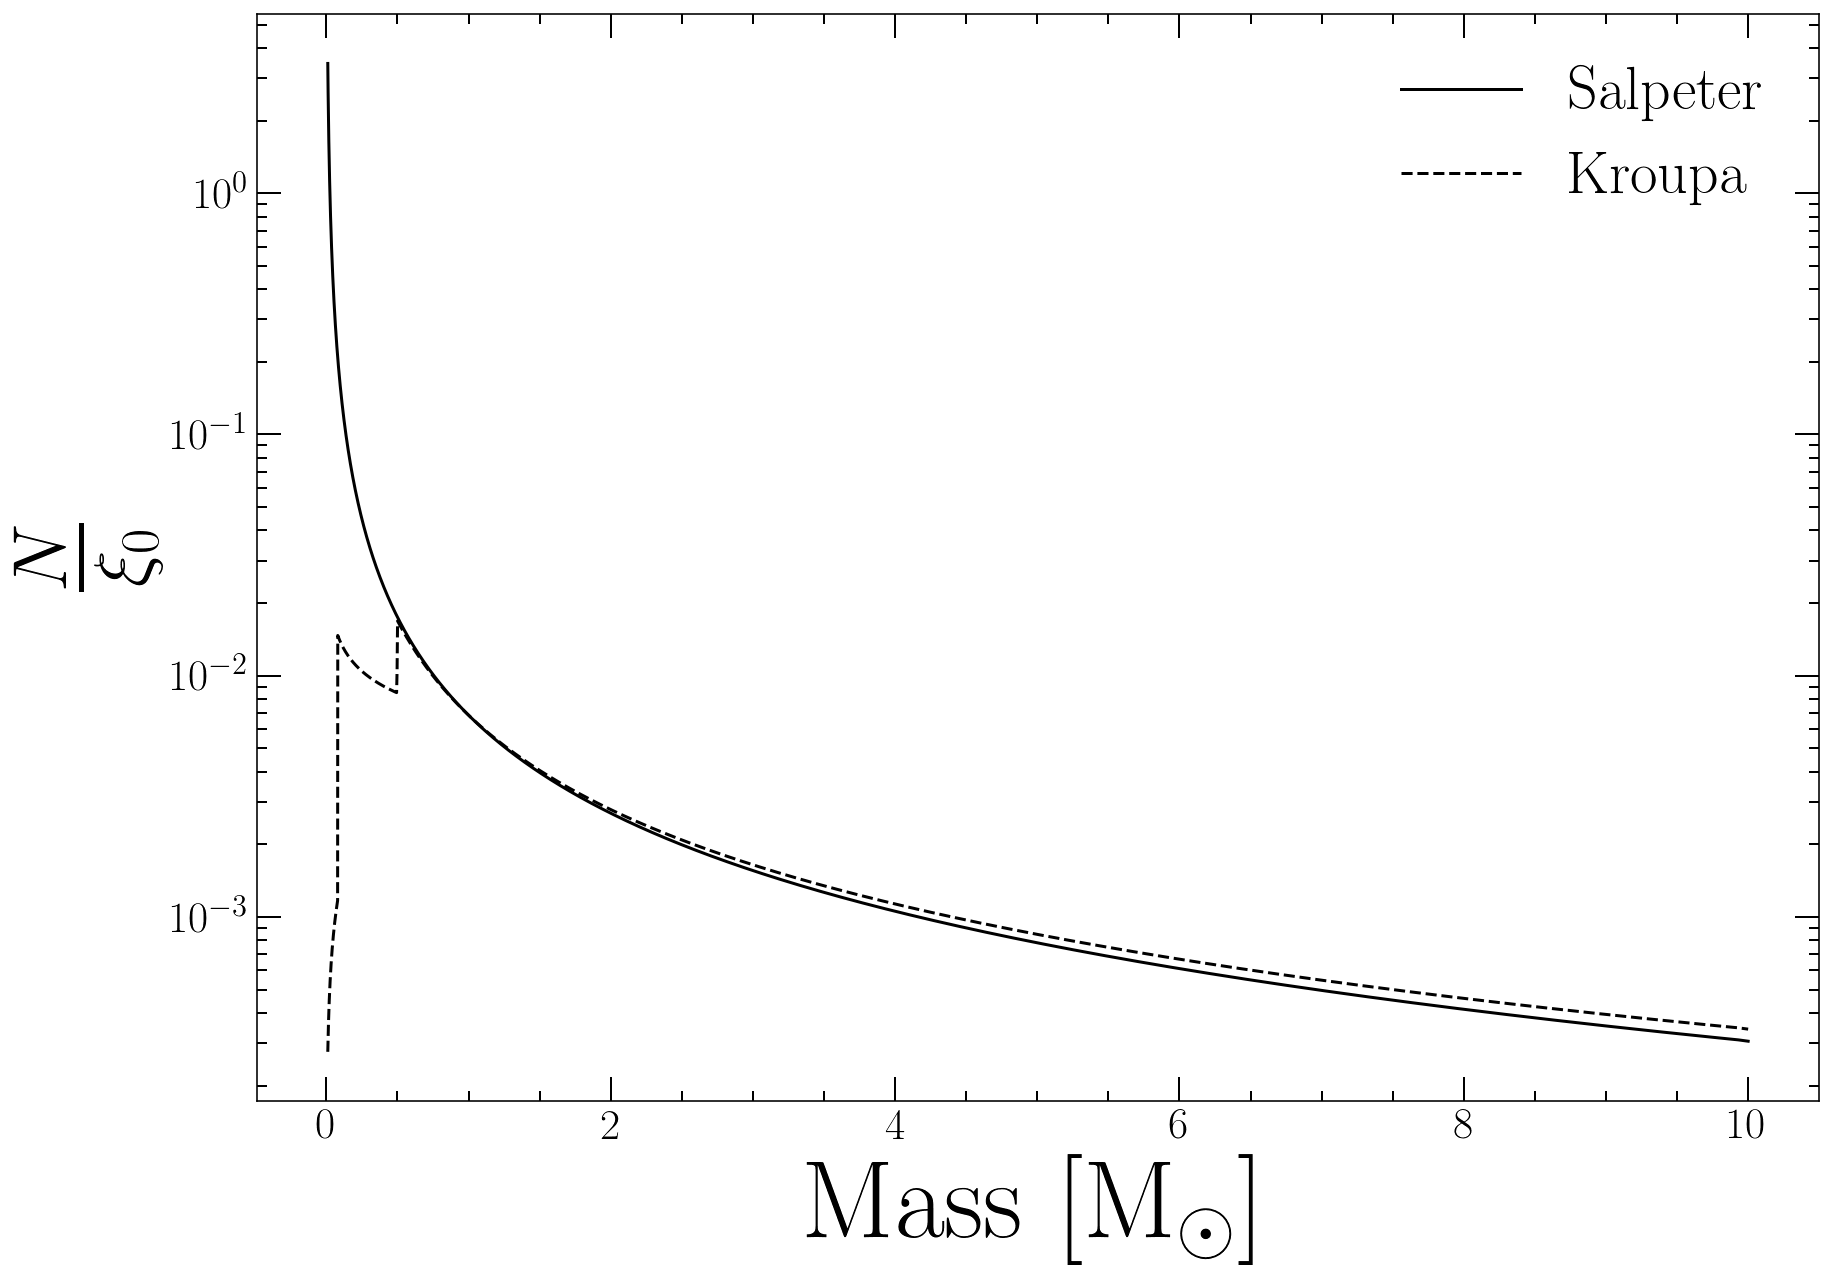

In [86]:
m = np.logspace(-2,1, 1000)
dm = np.gradient(m)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
# fig.patch.set_facecolor(bgColor)
# ax.set_facecolor(bgColor)
ax.semilogy(m, Salpeter(m, dm, 1), label='Salpeter', color='black')
ax.semilogy(m, Kroupa(m, dm, 1), label='Kroupa', color='black', linestyle='dashed')
# ax.loglog(m, ChabrierSingle(m, 1), label="Chabrier Single")

ax.set_xlabel('Mass [M$_{\odot}$]', fontsize=55)
ax.set_ylabel(r'$\frac{N}{\xi_{0}}$', fontsize=55)


ax.legend(fontsize=30, frameon=False)

ax.tick_params(length=12, width=1)
ax.tick_params(length=5, width=1, which='minor')
ax.tick_params(axis='both', which='major', labelsize=22)
fig.savefig("figures/IMFBoth.png", bbox_inches="tight", transparent=True)

In [87]:
dm = np.gradient(m)

In [88]:
dm[0]

6.938631476027628e-05

In [89]:
m[1]-m[0]

6.938631476027628e-05

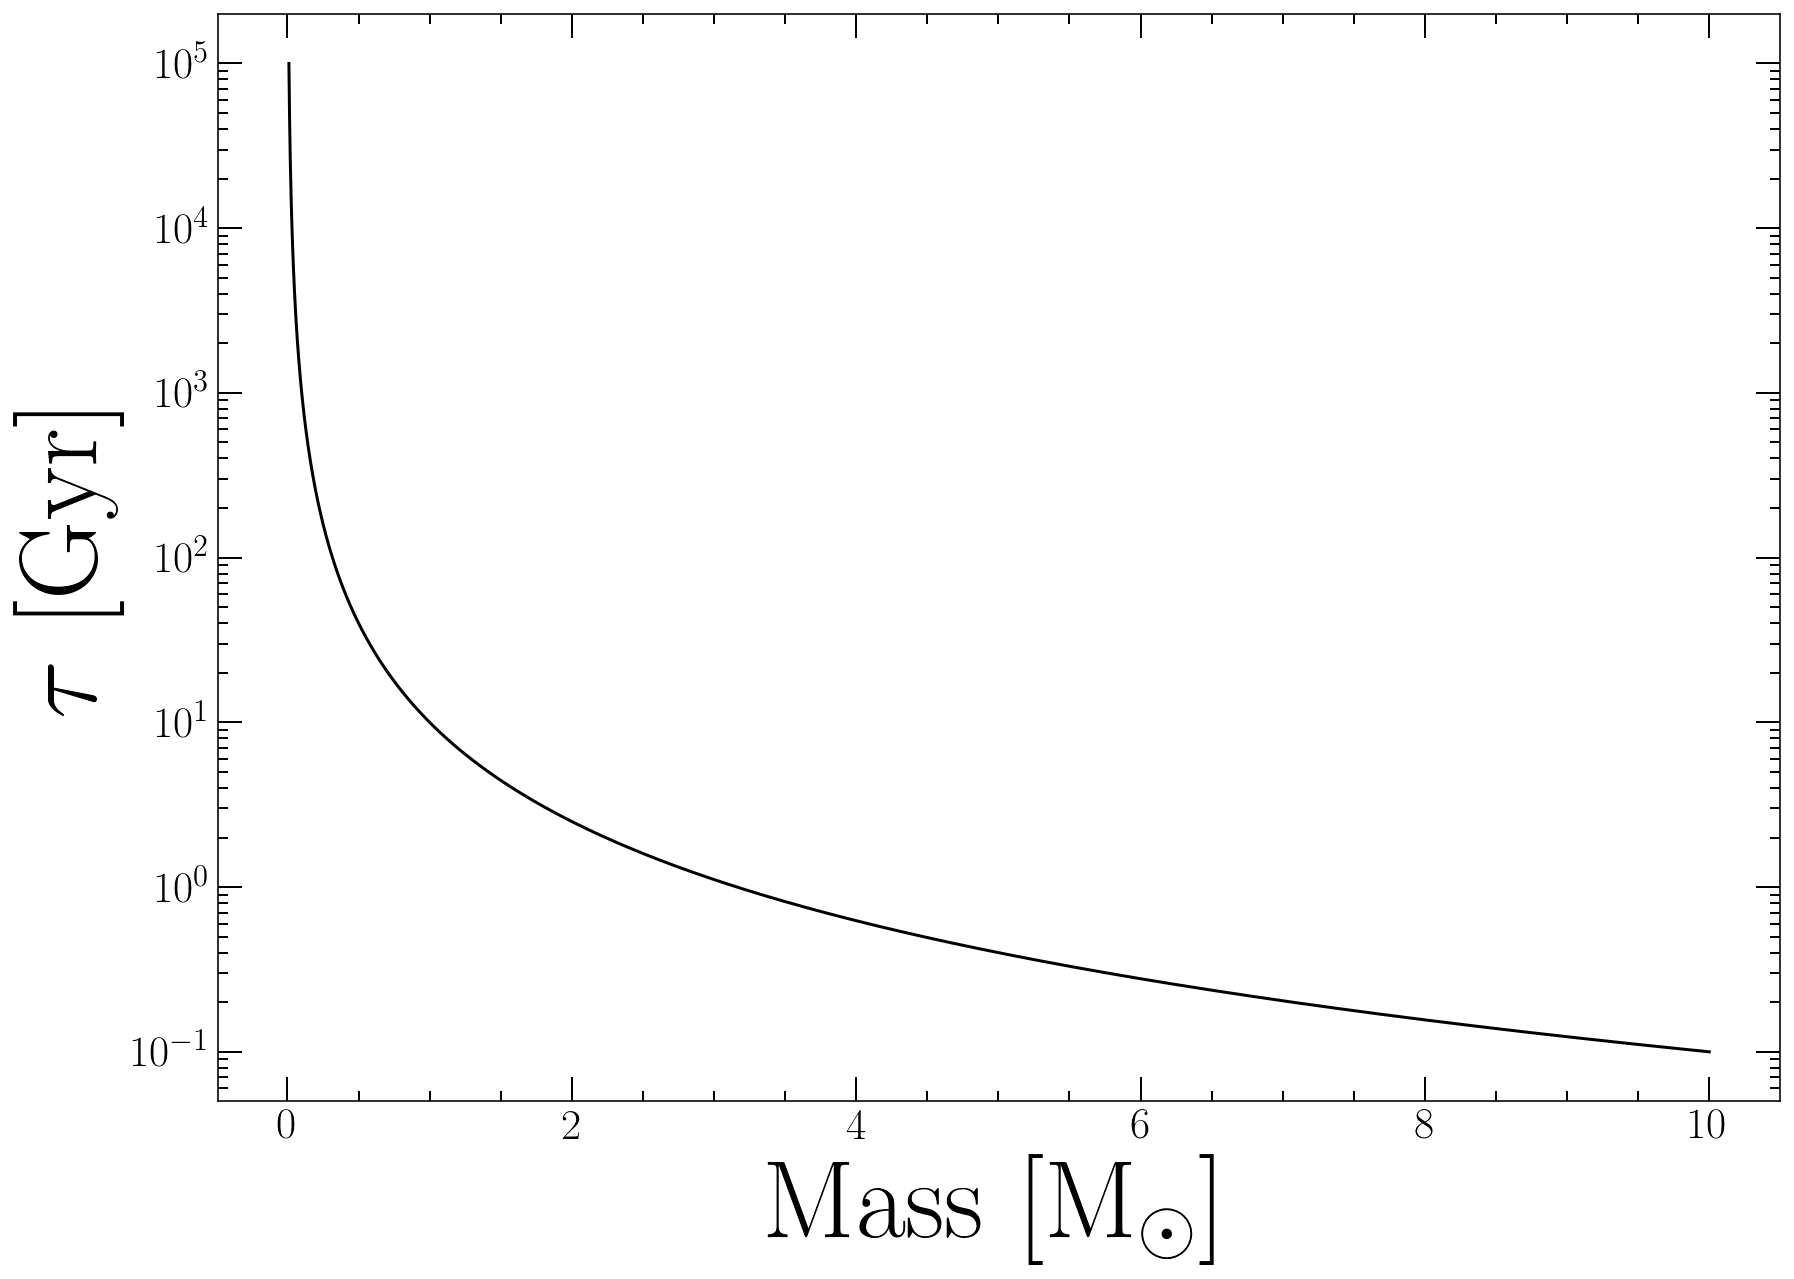

In [90]:
tau = lambda x, tau0: tau0 * x**-2 
m = np.logspace(-2, 1, 1000)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.semilogy(m, tau(m, 10), color='black')

ax.set_xlabel('Mass [M$_{\odot}$]', fontsize=55)
ax.set_ylabel(r'$\tau$ [Gyr]', fontsize=55)

ax.tick_params(length=12, width=1)
ax.tick_params(length=5, width=1, which='minor')
ax.tick_params(axis='both', which='major', labelsize=22)
fig.savefig("figures/MSLifeTime.png", bbox_inches="tight", transparent=True)

In [97]:
j = pd.read_csv("Gaia100ly.csv")
j = j.dropna(subset=['bp_rp', 'phot_g_mean_mag'])

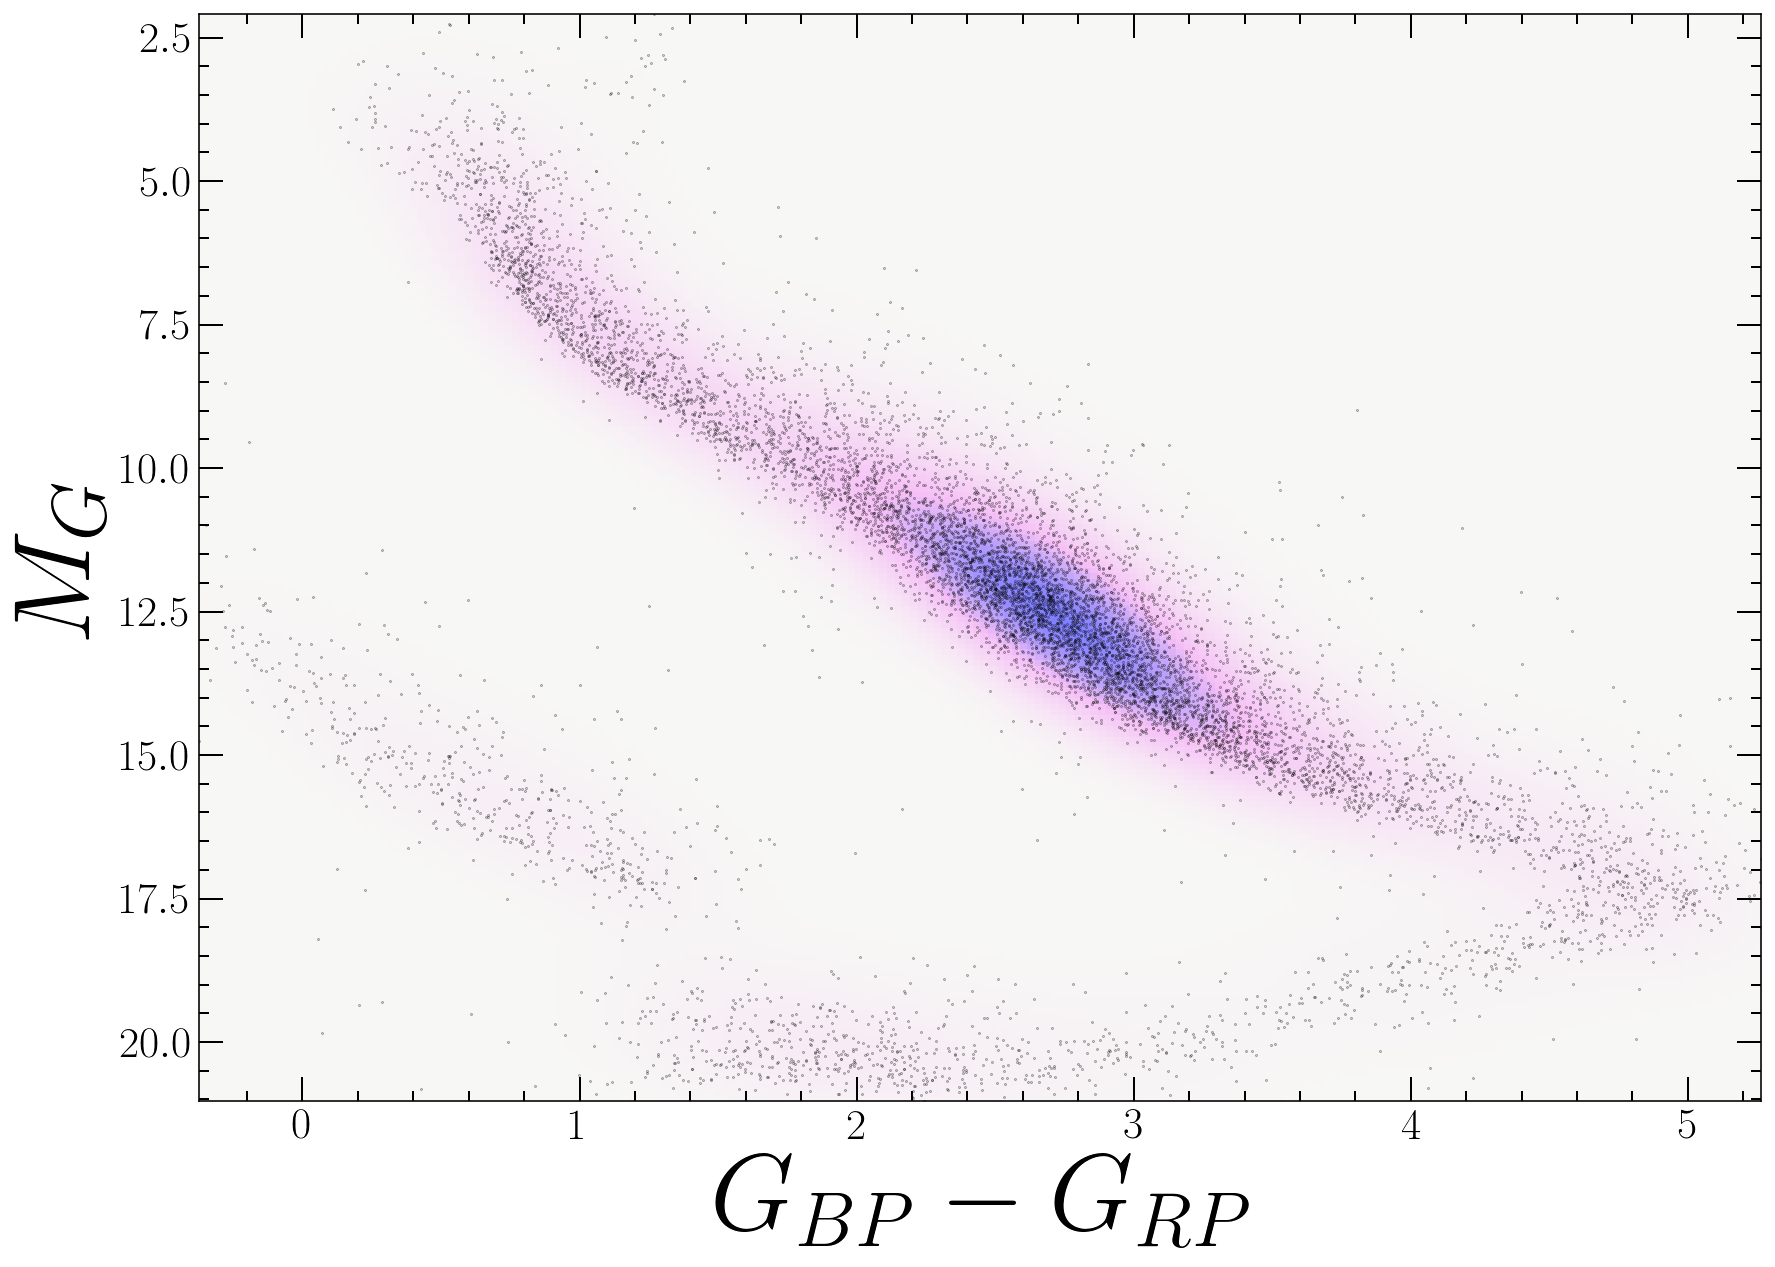

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.scatter(j['bp_rp'], j['phot_g_mean_mag'],s=0.1, color='black', alpha=0.5)
# fig.patch.set_facecolor(bgColor)
# ax.set_facecolor(bgColor)
add_kde_to_ax(j['bp_rp'], j['phot_g_mean_mag'], ax, alpha=0.5)
ax.invert_yaxis()

ax.set_xlabel("$G_{BP} - G_{RP}$", fontsize=55)
ax.set_ylabel("$M_{G}$", fontsize=55)
ax.tick_params(length=12, width=1)
ax.tick_params(length=5, width=1, which='minor')
ax.tick_params(axis='both', which='major', labelsize=22)

fig.savefig("figures/LocalCMD100ly.png", bbox_inches='tight', transparent=True)